## Bayesian mixture models for sex-specific genetic variance in anthropometric traits
##### Emily Flynn
##### BIODS 215
##### 6/9/2017

Code for running mixture model simulations and applying models to data. 

This code uses functions from "project_utils.R", and STAN models in files "model1.stan", and "model2.stan" the same directory. It assumes that the biods-github directory is located at the level above the current directory, and uses data from that. 

In [1]:
# Load functions
source("project_utils.R")
set.seed(607)

Loading required package: MASS
Loading required package: Matrix
Loading required package: mnormt


### MODEL 1 SIMULATIONS

In [4]:
seq(0.1, 0.9, 0.1)
sample(seq(0.0005, 0.003, 0.0001), )

[1] 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9

[1] 0.0005 0.0006 0.0007 0.0008 0.0009 0.0010 0.0011 0.0012 0.0013 0.0014
[11] 0.0015 0.0016 0.0017 0.0018 0.0019 0.0020 0.0021 0.0022 0.0023 0.0024
[21] 0.0025 0.0026 0.0027 0.0028 0.0029 0.0030

In [5]:
model1Sim <- function(N, p, Sigma){
zeros <- c(0,0)

    # sample squared SEs
    se2 <- simSE2(N)

    ### SAMPLE BETAS FOR EACH MODEL
    # M0
    n.m0 <- floor(p[1]*N)
    se.m0 <- matrix(se2[1:(2*n.m0)], n.m0, 2)
    betas.m0 <- do.call(rbind, lapply(1:n.m0, function(x) mvrnorm(1, zeros, diag(se.m0[x,]))))

    # M1
    n.m1 <- N - n.m0
    se.m1 <- matrix(se2[(2*n.m0+1):(2*N)], n.m1, 2)
    betas.m1 <- do.call(rbind, lapply(1:n.m1, function(x) mvrnorm(1, zeros, diag(se.m1[x,])+Sigma)))

    # put together
    betas <- rbind(betas.m0, betas.m1)
    ses <- rbind(se.m0, se.m1)

    cov.data.sim <- list(
        N = N,
        M = 2,
        B = betas,
        SE = ses,
        K = 2
    )
    return(cov.data.sim)
}



N <- 1000 # number of samples
p <- c(0.5, 0.5) # fraction in each component (null, non-null)
S <- matrix(c(0.0012,0.0005, 0.0005, 0.0010),2,2)
fixS <- nearPD(S)$mat # nearest positive definite matrix
cov.data.M1.sim <- model1Sim(N, p, fixS)


# try a range of pi

# tray a range of S (0.0005 to 0.003)


2 x 2 Matrix of class "dpoMatrix"
       [,1]  [,2]
[1,] 0.0012 5e-04
[2,] 0.0005 1e-03


In [6]:
start.time <- Sys.time()
# run stan to estimate the covariance
library(rstan)
options(warn=-1)
fit1_sim <- stan(
  file = "../models/model1_no_loglik.stan",  # Stan program
  data = cov.data.M1.sim,    # named list of data
  chains = 4,             # number of Markov chains
  warmup = 200,          # number of warmup iterations per chain
  iter = 800,            # total number of iterations per chain
  cores = 200,              
  refresh = 200          # show progress every 'refresh' iterations
  )
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

ERROR: Error in library(rstan): there is no package called ‘rstan’


Inference for Stan model: model1_no_loglik.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean      sd       2.5%        50%      97.5% n_eff
Sigma[1,1]    0.00123 0.00000 0.00012    0.00101    0.00122    0.00148  3264
Sigma[1,2]    0.00059 0.00000 0.00009    0.00043    0.00059    0.00077  3105
Sigma[2,1]    0.00059 0.00000 0.00009    0.00043    0.00059    0.00077  3105
Sigma[2,2]    0.00118 0.00000 0.00012    0.00097    0.00117    0.00142  3359
pi[1]         0.52946 0.00050 0.02768    0.47421    0.52971    0.58268  3088
pi[2]         0.47054 0.00050 0.02768    0.41732    0.47029    0.52579  3088
lp__       4227.81890 0.03271 1.41519 4224.21496 4228.16561 4229.56797  1872
              Rhat
Sigma[1,1] 0.99992
Sigma[1,2] 0.99966
Sigma[2,1] 0.99966
Sigma[2,2] 0.99975
pi[1]      0.99989
pi[2]      0.99989
lp__       1.00052

Samples were drawn using NUTS(diag_e) at Fri Oct 18 20:01:35 2019.
Fo

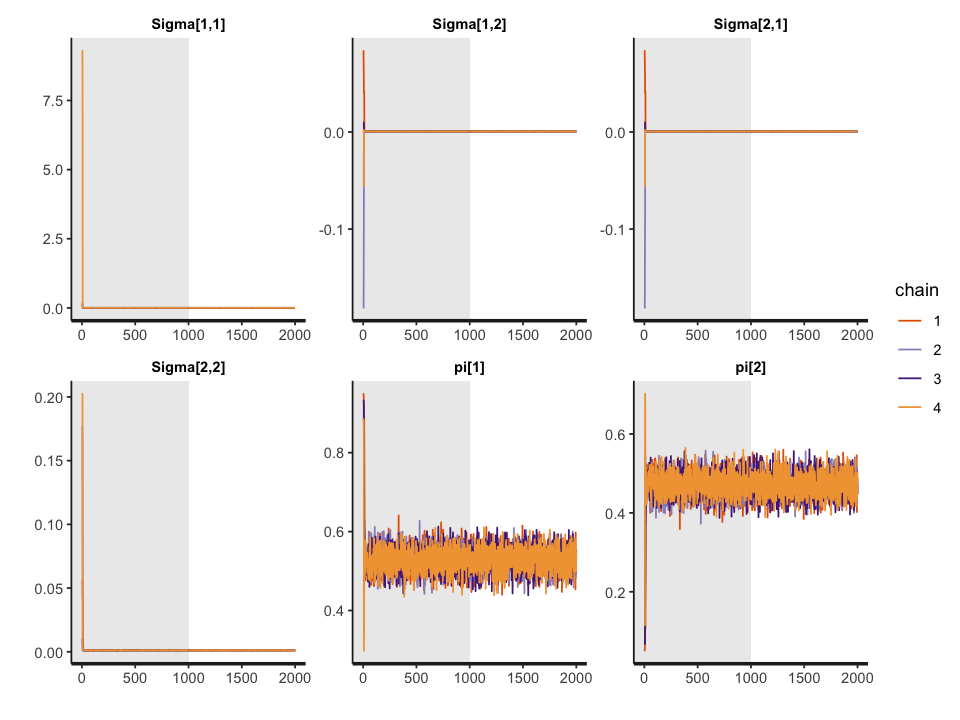

In [7]:
print(fit1_sim, pars=c("Sigma", "pi", "lp__"), probs=c(0.025, 0.5, 0.975), digits_summary=5)
options(repr.plot.width=8, repr.plot.height=6)
traceplot(fit1_sim, pars = c("Sigma", "pi"), inc_warmup = TRUE, nrow = 2)

In [6]:
save(fit1_sim, cov.data.M1.sim, file="sim1.RData")

### MODEL 1 DATA

In [7]:
all.bmi.dat <- lapply(1:22, function(x){ getData(as.character(x), "21001")})
all.height.dat <- lapply(1:22, function(x){ getData(as.character(x), "50")})
all.hc.dat <- lapply(1:22, function(x){ getData(as.character(x), "49")})

In [ ]:
bmi.filt <- filterSE(all.bmi.dat)
bmi.filt.sampled <- topPsample(dat=bmi.filt, cutoff.p=10**(-5), frac.top=0.5, K=2)
bmi.cov.dat <- bmi.filt.sampled$dat

height.filt <- filterSE(all.height.dat)
height.filt.sampled <- topPsample(dat=height.filt, cutoff.p=10**(-5), frac.top=0.5, K=2)
height.cov.dat <- height.filt.sampled$dat

hc.filt <- filterSE(all.hc.dat)
hc.filt.sampled <- topPsample(dat=hc.filt, cutoff.p=10**(-5), frac.top=0.5, K=2)
hc.cov.dat <- hc.filt.sampled$dat

In [9]:
save(hc.filt.sampled, height.filt.sampled, bmi.filt.sampled, file="sampled_data.RData")

In [ ]:
## run stan
library(rstan)
options(warn=-1)
fit1_bmi <- stan(
  file = "model1.stan",  # Stan program
  data = bmi.cov.dat,    # named list of data
  chains = 4,             # number of Markov chains
  warmup = 1000,          # number of warmup iterations per chain
  iter = 2000,            # total number of iterations per chain
  cores = 2,              # number of cores 
  refresh = 1000          # show progress every 'refresh' iterations
)

In [ ]:
## run stan
library(rstan)
options(warn=-1)
fit1_height <- stan(
  file = "model1.stan",  # Stan program
  data = height.cov.dat,    # named list of data
  chains = 4,             # number of Markov chains
  warmup = 1000,          # number of warmup iterations per chain
  iter = 2000,            # total number of iterations per chain
  cores = 2,              # number of cores 
  refresh = 1000          # show progress every 'refresh' iterations
)

In [ ]:
## run stan
library(rstan)
options(warn=-1)
fit1_hc <- stan(
  file = "model1.stan",  # Stan program
  data = hc.cov.dat,    # named list of data
  chains = 4,             # number of Markov chains
  warmup = 1000,          # number of warmup iterations per chain
  iter = 2000,            # total number of iterations per chain
  cores = 2,              # number of cores 
  refresh = 1000          # show progress every 'refresh' iterations
)


Inference for Stan model: model1_mixture.
4 chains, each with iter=500; warmup=200; thin=1; 
post-warmup draws per chain=300, total post-warmup draws=1200.

                 mean se_mean      sd       2.5%        50%      97.5% n_eff
Sigma[1,1]    0.00092 0.00000 0.00006    0.00081    0.00091    0.00104   630
Sigma[1,2]    0.00085 0.00000 0.00006    0.00075    0.00085    0.00097   509
Sigma[2,1]    0.00085 0.00000 0.00006    0.00075    0.00085    0.00097   509
Sigma[2,2]    0.00094 0.00000 0.00006    0.00083    0.00094    0.00106   550
pi[1]         0.15530 0.00103 0.02503    0.10807    0.15537    0.20504   594
pi[2]         0.84470 0.00103 0.02503    0.79496    0.84463    0.89193   594
lp__       3785.08615 0.06366 1.48446 3781.42958 3785.48363 3786.84519   544
              Rhat
Sigma[1,1] 0.99881
Sigma[1,2] 0.99895
Sigma[2,1] 0.99895
Sigma[2,2] 0.99991
pi[1]      1.00112
pi[2]      1.00112
lp__       1.01121

Samples were drawn using NUTS(diag_e) at Thu Jun  8 10:12:34 2017.
For eac

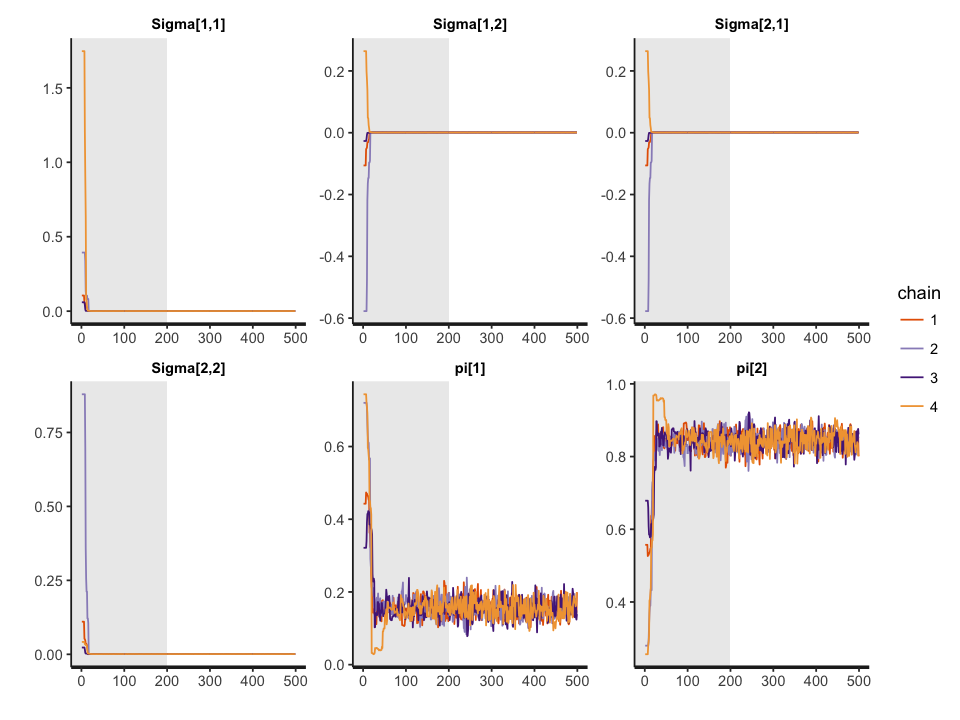

In [13]:
print(fit1_bmi, pars=c("Sigma", "pi", "lp__"), probs=c(0.025, 0.5, 0.975), digits_summary = 5)
options(repr.plot.width=8, repr.plot.height=6)
traceplot(fit1_bmi, pars = c("Sigma", "pi"), inc_warmup = TRUE, nrow = 2)

In [30]:
lrt(height.cov.dat, fit1_height)
lrt(bmi.cov.dat, fit1_bmi)
lrt(hc.cov.dat, fit1_hc)

getRg(getSigma(fit1_height))
getRg(getSigma(fit1_bmi))
getRg(getSigma(fit1_hc))

[1] 1.465863

[1] 1.596746

[1] 1.38649


Call:
lm(formula = h_bmi[1, ] ~ h_bmi[2, ])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.040898 -0.002655 -0.001712  0.002189  0.031033 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.018270   0.001105   16.54   <2e-16 ***
h_bmi[2, ]  0.986831   0.001277  772.99   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.007038 on 760 degrees of freedom
  (82 observations deleted due to missingness)
Multiple R-squared:  0.9987,	Adjusted R-squared:  0.9987 
F-statistic: 5.975e+05 on 1 and 760 DF,  p-value: < 2.2e-16


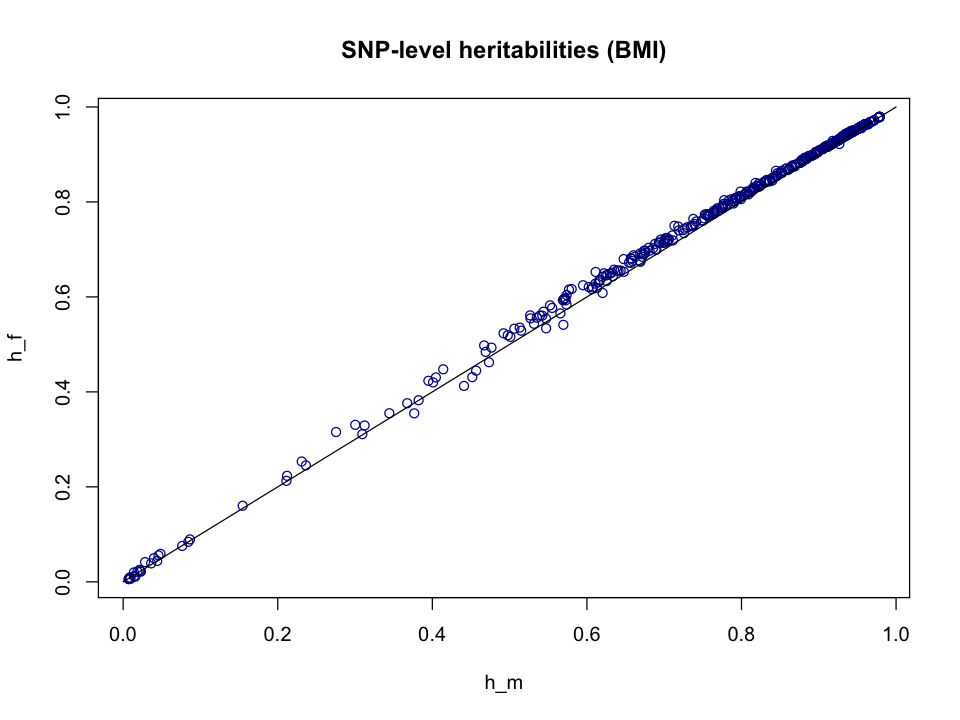


Call:
lm(formula = h_height[1, ] ~ h_height[2, ])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.065859 -0.006051 -0.003345  0.005441  0.050658 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.0507977  0.0007136   71.18   <2e-16 ***
h_height[2, ] 0.9605267  0.0008192 1172.58   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01189 on 5660 degrees of freedom
  (566 observations deleted due to missingness)
Multiple R-squared:  0.9959,	Adjusted R-squared:  0.9959 
F-statistic: 1.375e+06 on 1 and 5660 DF,  p-value: < 2.2e-16


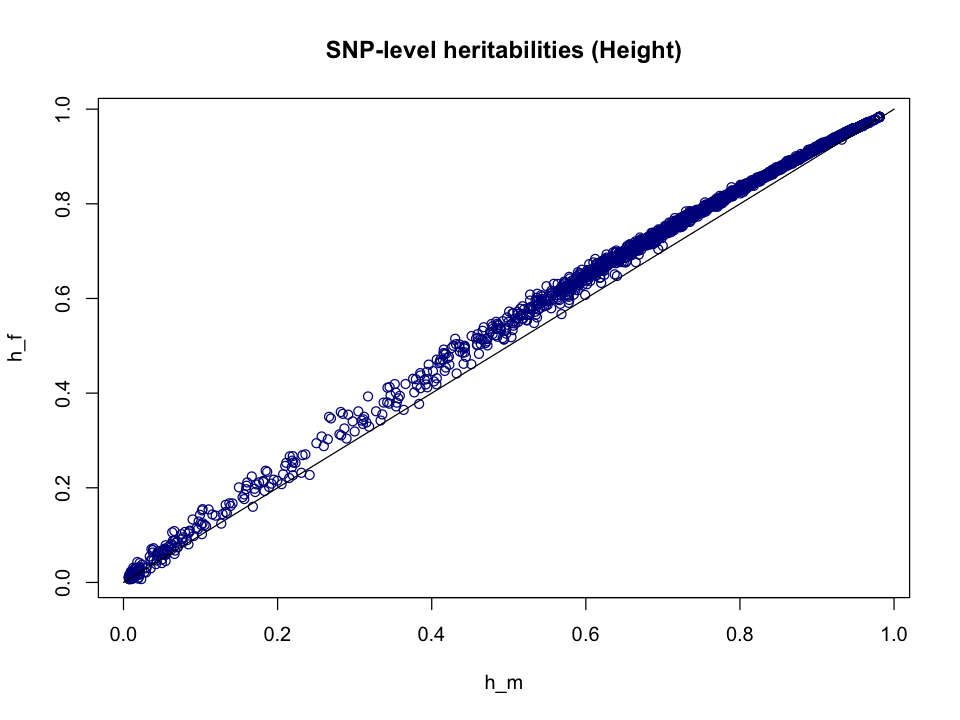


Call:
lm(formula = h_hc[1, ] ~ h_hc[2, ])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.045420 -0.000449  0.000868  0.001346  0.027488 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.0163746  0.0007280  -22.49   <2e-16 ***
h_hc[2, ]    1.0134488  0.0008534 1187.52   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.005765 on 1024 degrees of freedom
  (90 observations deleted due to missingness)
Multiple R-squared:  0.9993,	Adjusted R-squared:  0.9993 
F-statistic: 1.41e+06 on 1 and 1024 DF,  p-value: < 2.2e-16


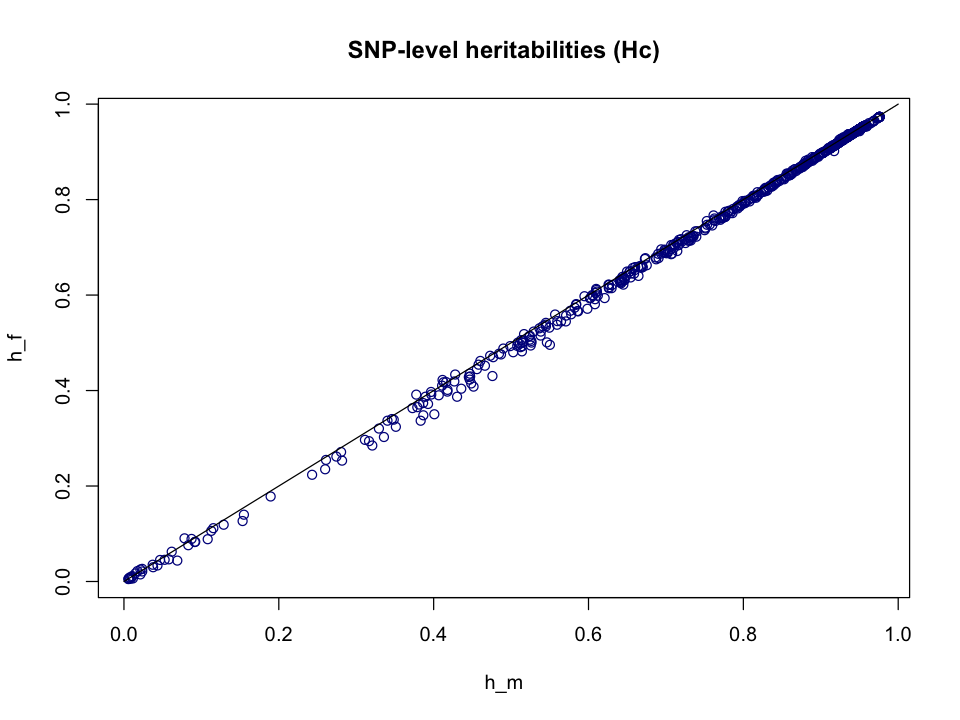

In [49]:


h_bmi <- getPlotHeritabilities(bmi.cov.dat, fit1_bmi, "BMI")

h_height <- getPlotHeritabilities(height.cov.dat, fit1_height, "Height")

h_hc <- getPlotHeritabilities(hc.cov.dat, fit1_hc, "Hc")


In [29]:
save(fit1_hc, fit1_height, fit1_bmi, file="fit1_data.RData")

### MODEL 2 SIMULATIONS

In [13]:
N <- 1000
p <- c(0.5, 0.2, 0.1, 0.2)
sigmasq <- c(0.005, 0.001, 0.002, 0.004) 
cov.data.M2.sim <- model2Sim(N, p, sigmasq)


In [15]:

# run stan to estimate the covariance
library(rstan)
options(warn=-1)
fit2_sim <- stan(
  file = "../models/model2.stan",  # Stan program
  data = cov.data.M2.sim,    # named list of data
  chains = 4,             # number of Markov chains
  warmup = 200,          # number of warmup iterations per chain
  iter = 600,            # total number of iterations per chain
  cores = 2,              
  refresh = 200          # show progress every 'refresh' iterations
  )


In [18]:
save(fit2_sim, cov.data.M2.sim, file="sim2.RData")

Inference for Stan model: model2.
4 chains, each with iter=600; warmup=200; thin=1; 
post-warmup draws per chain=400, total post-warmup draws=1600.

                 mean se_mean      sd        10%       2.5%      97.5% n_eff
sigmasq[1]    0.01518 0.00050 0.00209    0.01283    0.01194    0.01996    18
sigmasq[2]    0.44998 0.40172 2.35122    0.02394    0.02084    3.34480    34
sigmasq[3]    0.03837 0.00458 0.01331    0.01769    0.01508    0.06505     8
sigmasq[4]    0.04235 0.00404 0.01455    0.02106    0.01763    0.07386    13
pi[1]         0.64080 0.00540 0.02455    0.60993    0.59504    0.69200    21
pi[2]         0.21613 0.00757 0.02572    0.18032    0.15766    0.26189    12
pi[3]         0.07226 0.01464 0.03326    0.00175    0.00032    0.11407     5
pi[4]         0.07082 0.01673 0.03685    0.04198    0.03695    0.16607     5
lp__       3556.22848 1.02301 2.77799 3552.17511 3549.62719 3559.65735     7
              Rhat
sigmasq[1] 1.15579
sigmasq[2] 1.07514
sigmasq[3] 1.32344
sigma

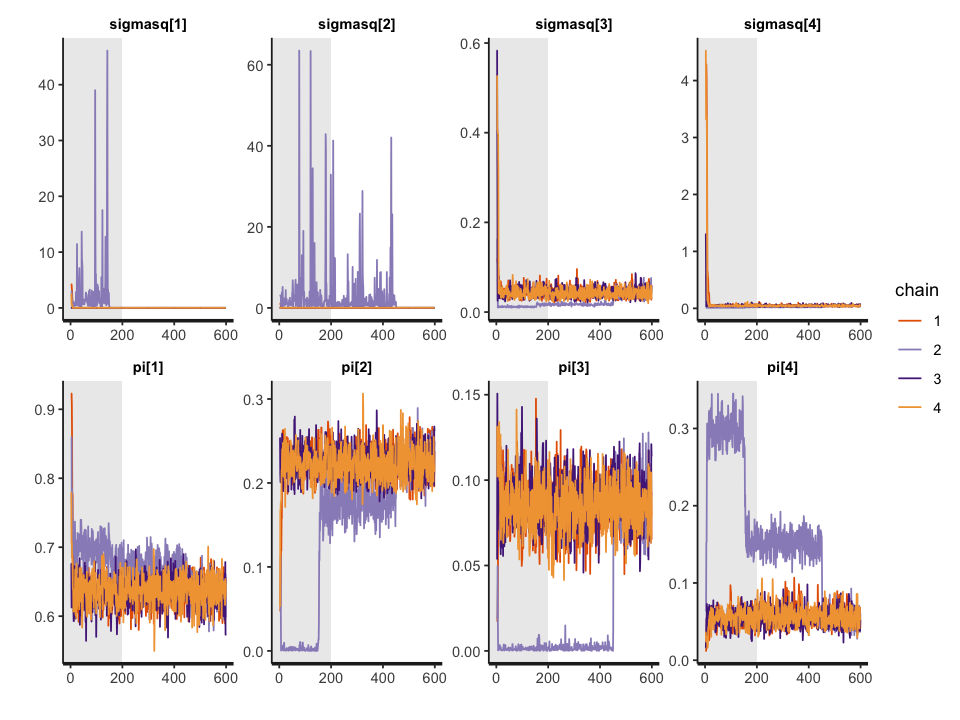

In [16]:
print(fit2_sim, pars=c("sigmasq", "pi", "lp__"), probs=c(0.1, 0.025, 0.975), digits_summary = 5)
options(repr.plot.width=8, repr.plot.height=6)
traceplot(fit2_sim, pars = c("sigmasq", "pi"), inc_warmup = TRUE, nrow = 2)

### MODEL 2 DATA

In [24]:
library(rstan)
options(warn=-1)
bmi.cov.dat4 <- bmi.cov.dat
bmi.cov.dat4$K <- 4
fit2_bmi <- stan(
  file = "model2.stan",  # Stan program
  data = bmi.cov.dat4,    # named list of data
  chains = 4,             # number of Markov chains
  warmup = 1000,          # number of warmup iterations per chain
  iter = 2000,            # total number of iterations per chain
  cores = 4,              # number of cores (using 2 just for the vignette)
  refresh = 1000          # show progress every 'refresh' iterations
  )

In [25]:
library(rstan)
options(warn=-1)
height.cov.dat4 <- height.cov.dat
height.cov.dat4$K <- 4
fit2_height <- stan(
  file = "model2.stan",  # Stan program
  data = height.cov.dat4,    # named list of data
  chains = 4,             # number of Markov chains
  warmup = 1000,          # number of warmup iterations per chain
  iter = 2000,            # total number of iterations per chain
  cores = 4,              # number of cores (using 2 just for the vignette)
  refresh = 1000          # show progress every 'refresh' iterations
  )

In [26]:
library(rstan)
options(warn=-1)
hc.cov.dat4 <- hc.cov.dat
hc.cov.dat4$K <- 4
fit2_hc <- stan(
  file = "model2.stan",  # Stan program
  data = hc.cov.dat4,    # named list of data
  chains = 4,             # number of Markov chains
  warmup = 1000,          # number of warmup iterations per chain
  iter = 2000,            # total number of iterations per chain
  cores = 4,              # number of cores (using 2 just for the vignette)
  refresh = 1000          # show progress every 'refresh' iterations
  )

In [27]:
save(fit2_hc, fit2_height, fit2_bmi, file="fit2_data.RData")

In [ ]:
# Look at sex-specific SNPs

cats_hc <- getAllCats(hc.cov.dat4, fit2_hc)
table(cats_hc)
sexSpecSNPtables(hc.filt.sampled, hc.filt$`1`, hc.filt$`2`, cats_hc)

cats_height <- getAllCats(height.cov.dat4, fit2_height)
table(cats_height)
sexSpecSNPtables(height.filt.sampled, height.filt$`1`, height.filt$`2`, cats_height)

cats_bmi <- getAllCats(bmi.cov.dat4, fit2_bmi)
table(cats_bmi)
sexSpecSNPtables(bmi.filt.sampled, bmi.filt$`1`, bmi.filt$`2`, cats_bmi)